# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_085  C9JF17;P05090                25.054
Sample_062  A0A0C4DFZ2;P15289;P15289-2   14.094
Sample_066  A0A0B4J1V2                   16.605
Sample_186  P37802;P37802-2;X6RJP6       14.598
Sample_094  P05067;P05067-11;P05067-8    19.739
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_009  Q8NFP4;Q8NFP4-2            16.677
Sample_132  Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.895
Sample_127  P04003                     14.565
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.855
            A0A075B6Q5                 12.847
            A0A075B6R2                 13.619
            A0A075B6S5                 12.009
            A0A087WSY4                 14.502
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.595
            Q9UI40;Q9UI40-2            11.827
            Q9UIW2                     12.606
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.714
            Q9UP79                     11.855
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.671,15.050,16.842,19.863,16.408,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.609,19.067,...,15.528,15.576,13.475,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.235,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.956,17.705,17.039,16.264,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,16.060,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.563,15.345,17.084,18.708,14.249,19.433,11.781,10.794
Sample_207,15.739,16.877,15.469,16.898,15.168,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.337,12.875,13.478,13.099,12.800,13.330,13.162,13.375,13.473,14.113
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.000,19.067,16.127,...,11.359,12.790,12.791,12.384,12.945,12.345,12.820,12.909,12.343,12.745
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.511,12.728,13.137,13.151,13.399,12.974,11.465,13.133,12.425,12.532
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,10.521,12.632,14.061,12.467,11.296,12.997,13.686,12.471,14.749,13.032
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.770,13.435,12.245,12.464,12.408,11.085,12.354,13.670,12.816,13.418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.089,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 316.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.89it/s]

100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.52it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.00it/s]

100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.62it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.41it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.03it/s]

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

100%|██████████| 5/5 [00:01<00:00,  4.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.71it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.90it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.22it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.98it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

100%|██████████| 6/6 [00:01<00:00,  4.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.81it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.34it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.90it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.09it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.16it/s]

100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.26it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.70it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.90it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.81it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.66it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.54it/s]

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.27it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.43it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.50it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.13it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.58it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.52it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.41it/s]

100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.89it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.52it/s]

 30%|███       | 3/10 [00:00<00:01,  5.64it/s]

 40%|████      | 4/10 [00:00<00:01,  4.60it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.33it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.06it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.01it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.92it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.87it/s]

100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.68it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.30it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.95it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.90it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.73it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.46it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.49it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.51it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.66it/s]

100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.07it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.57it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.43it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.82it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.37it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.36it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.15it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  3.89it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.82it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.01it/s]

100%|██████████| 12/12 [00:02<00:00,  4.11it/s]

100%|██████████| 12/12 [00:02<00:00,  4.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.13it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.89it/s]

 31%|███       | 4/13 [00:01<00:02,  3.16it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.98it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.80it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.81it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.77it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.75it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.79it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.70it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.92it/s]

100%|██████████| 13/13 [00:04<00:00,  3.25it/s]

100%|██████████| 13/13 [00:04<00:00,  3.05it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.97it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.24it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.66it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.29it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.98it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.90it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.78it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.87it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.81it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.76it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.85it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.37it/s]

100%|██████████| 14/14 [00:03<00:00,  3.20it/s]

100%|██████████| 14/14 [00:03<00:00,  3.82it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.69it/s]

 20%|██        | 3/15 [00:00<00:03,  3.71it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.23it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.01it/s]

 40%|████      | 6/15 [00:01<00:02,  3.20it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.10it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.07it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.12it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.29it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.39it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.32it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.38it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.46it/s]

100%|██████████| 15/15 [00:04<00:00,  3.48it/s]

100%|██████████| 15/15 [00:04<00:00,  3.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.005          0.756 0.355       0.114   
2             0.003 0.000      0.035 0.000          0.753 0.079       0.701   
3             0.003 0.000      0.035 0.002          0.746 0.084       0.697   
4             0.003 0.001      0.036 0.009          0.760 0.081       0.722   
5             0.003 0.000      0.036 0.004          0.783 0.079       0.768   
6             0.004 0.002      0.037 0.005          0.786 0.085       0.771   
7             0.003 0.000      0.037 0.007          0.778 0.085       0.763   
8             0.003 0.000      0.036 0.000          0.813 0.079       0.809   
9             0.004 0.002      0.037 0.006          0.818 0.078       0.806   
10            0.003 0.000      0.034 0.006          0.815 0.079       0.809   
11            0.004 0.000      0.036 0.002          0.814 0.082       0.805   
12            0.004 0.003      0.034 0.009          0.808 0.078       0.801   
13            0.004 0.003      0.040 0.019          0.806 0.080       0.795   
14            0.004 0.002      0.045 0.017          0.803 0.084       0.794   
15            0.005 0.004      0.049 0.018          0.793 0.084       0.782   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.191 0.130                  0.550 0.042        0.856   
2          0.119   0.720 0.082                  0.766 0.062        0.859   
3          0.108   0.715 0.076                  0.760 0.059        0.855   
4          0.105   0.735 0.074                  0.776 0.058        0.857   
5          0.094   0.772 0.067                  0.805 0.056        0.870   
6          0.094   0.774 0.068                  0.807 0.056        0.901   
7          0.102   0.766 0.075                  0.801 0.060        0.898   
8          0.096   0.807 0.068                  0.835 0.058        0.908   
9          0.095   0.809 0.069                  0.837 0.059        0.908   
10         0.099   0.808 0.070                  0.836 0.060        0.907   
11         0.100   0.806 0.072                  0.834 0.061        0.905   
12         0.103   0.800 0.072                  0.830 0.060        0.906   
13         0.106   0.796 0.074                  0.827 0.062        0.906   
14         0.106   0.794 0.075                  0.825 0.064        0.905   
15         0.099   0.783 0.071                  0.815 0.060        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.825 0.091        210.000 0.000  
2          0.053                  0.834 0.065        210.000 0.000  
3          0.051                  0.829 0.062        210.000 0.000  
4          0.047                  0.829 0.058        210.000 0.000  
5          0.051                  0.839 0.067        210.000 0.000  
6          0.048                  0.878 0.057        210.000 0.000  
7          0.048                  0.873 0.059        210.000 0.000  
8          0.048                  0.891 0.052        210.000 0.000  
9          0.048                  0.891 0.051        210.000 0.000  
10         0.049                  0.890 0.053        210.000 0.000  
11         0.049                  0.887 0.054        210.000 0.000  
12         0.049                  0.891 0.053        210.000 0.000  
13         0.049                  0.891 0.053        210.000 0.000  
14         0.051                  0.890 0.054        210.000 0.000  
15         0.050                  0.885 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 527.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.24it/s]

100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.86it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.88it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.96it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.43it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.80it/s]

100%|██████████| 6/6 [00:01<00:00,  2.77it/s]

100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.76it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.73it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.99it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.73it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.58it/s]

100%|██████████| 7/7 [00:01<00:00,  3.00it/s]

100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.14it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.89it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.66it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.68it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.52it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.50it/s]

100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.25it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.28it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.10it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.13it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.12it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.08it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.11it/s]

100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.13it/s]

 30%|███       | 3/10 [00:00<00:02,  2.93it/s]

 40%|████      | 4/10 [00:01<00:02,  2.76it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.71it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.95it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.91it/s]

 90%|█████████ | 9/10 [00:03<00:00,  3.01it/s]

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.32it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.07it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.70it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.79it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.94it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.89it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.05it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.13it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.14it/s]

100%|██████████| 11/11 [00:03<00:00,  3.14it/s]

100%|██████████| 11/11 [00:03<00:00,  3.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.58it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.75it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.07it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.11it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.22it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.22it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.16it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.22it/s]

100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

100%|██████████| 12/12 [00:03<00:00,  3.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.90it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.58it/s]

 31%|███       | 4/13 [00:01<00:03,  2.74it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.49it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.29it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.18it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.33it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.40it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.53it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.74it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.96it/s]

100%|██████████| 13/13 [00:04<00:00,  2.92it/s]

100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.16it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.59it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.98it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.56it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.45it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.30it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.98it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.83it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.58it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.47it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.46it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.37it/s]

100%|██████████| 14/14 [00:04<00:00,  2.46it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.46it/s]

 20%|██        | 3/15 [00:00<00:03,  3.44it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.93it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.97it/s]

 40%|████      | 6/15 [00:01<00:03,  2.96it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.80it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.91it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.99it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.09it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.15it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.29it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.28it/s]

100%|██████████| 15/15 [00:04<00:00,  3.26it/s]

100%|██████████| 15/15 [00:04<00:00,  3.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.040 0.012          0.087 0.248       0.009   
2             0.003 0.001      0.039 0.012          0.718 0.273       0.207   
3             0.004 0.003      0.039 0.011          0.801 0.087       0.721   
4             0.004 0.002      0.039 0.011          0.799 0.084       0.709   
5             0.004 0.003      0.041 0.014          0.791 0.098       0.725   
6             0.005 0.004      0.051 0.020          0.787 0.095       0.761   
7             0.006 0.006      0.044 0.016          0.786 0.097       0.764   
8             0.004 0.003      0.051 0.020          0.791 0.090       0.789   
9             0.005 0.004      0.050 0.018          0.789 0.093       0.791   
10            0.006 0.005      0.055 0.020          0.800 0.089       0.814   
11            0.005 0.004      0.054 0.019          0.802 0.087       0.810   
12            0.004 0.003      0.049 0.018          0.797 0.089       0.805   
13            0.006 0.005      0.056 0.019          0.803 0.085       0.815   
14            0.004 0.002      0.038 0.012          0.817 0.092       0.831   
15            0.005 0.004      0.055 0.019          0.819 0.090       0.827   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.869   
2          0.114   0.302 0.142                  0.569 0.053        0.720   
3          0.112   0.754 0.081                  0.794 0.061        0.894   
4          0.115   0.746 0.082                  0.789 0.062        0.891   
5          0.109   0.752 0.081                  0.791 0.063        0.893   
6          0.127   0.767 0.084                  0.804 0.068        0.893   
7          0.128   0.767 0.082                  0.804 0.067        0.892   
8          0.098   0.785 0.066                  0.816 0.056        0.899   
9          0.097   0.785 0.066                  0.816 0.057        0.897   
10         0.105   0.802 0.072                  0.831 0.061        0.913   
11         0.110   0.800 0.072                  0.830 0.060        0.913   
12         0.110   0.794 0.070                  0.825 0.058        0.913   
13         0.117   0.803 0.076                  0.833 0.063        0.917   
14         0.104   0.819 0.074                  0.845 0.063        0.924   
15         0.105   0.818 0.072                  0.845 0.062        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.836 0.088        210.000 0.000  
2          0.117                  0.678 0.130        210.000 0.000  
3          0.046                  0.871 0.055        210.000 0.000  
4          0.047                  0.865 0.057        210.000 0.000  
5          0.049                  0.874 0.054        210.000 0.000  
6          0.050                  0.872 0.059        210.000 0.000  
7          0.049                  0.872 0.058        210.000 0.000  
8          0.051                  0.879 0.058        210.000 0.000  
9          0.053                  0.877 0.062        210.000 0.000  
10         0.045                  0.889 0.054        210.000 0.000  
11         0.045                  0.888 0.054        210.000 0.000  
12         0.045                  0.887 0.055        210.000 0.000  
13         0.044                  0.895 0.053        210.000 0.000  
14         0.041                  0.905 0.049        210.000 0.000  
15         0.041                  0.905 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1057.03it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.84it/s]

100%|██████████| 2/2 [00:00<00:00, 17.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 27.51it/s]

100%|██████████| 3/3 [00:00<00:00, 26.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.61it/s]

100%|██████████| 4/4 [00:00<00:00, 16.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.83it/s]

100%|██████████| 5/5 [00:00<00:00, 17.13it/s]

100%|██████████| 5/5 [00:00<00:00, 17.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.12it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.13it/s]

100%|██████████| 6/6 [00:00<00:00, 13.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.73it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.42it/s]

100%|██████████| 7/7 [00:00<00:00, 13.62it/s]

100%|██████████| 7/7 [00:00<00:00, 14.47it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 13.96it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.41it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.99it/s]

100%|██████████| 8/8 [00:00<00:00, 12.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 24.09it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.84it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.57it/s]

100%|██████████| 9/9 [00:00<00:00, 16.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.32it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.69it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.91it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.69it/s]

100%|██████████| 10/10 [00:00<00:00, 14.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.71it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.85it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 15.17it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 15.00it/s]

100%|██████████| 11/11 [00:00<00:00, 14.97it/s]

100%|██████████| 11/11 [00:00<00:00, 15.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.96it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.21it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.88it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.06it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.82it/s]

100%|██████████| 12/12 [00:00<00:00, 13.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.15it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.65it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 18.76it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 17.78it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 16.52it/s]

100%|██████████| 13/13 [00:00<00:00, 16.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.74it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.85it/s]

 50%|█████     | 7/14 [00:00<00:00, 15.13it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.61it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.97it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.36it/s]

100%|██████████| 14/14 [00:00<00:00, 14.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.19it/s]

 40%|████      | 6/15 [00:00<00:00, 16.89it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 15.21it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.31it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.24it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.83it/s]

100%|██████████| 15/15 [00:00<00:00, 15.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.035 0.002          0.000 0.000       0.000   
2             0.005 0.004      0.050 0.020          0.682 0.116       0.506   
3             0.004 0.002      0.041 0.015          0.670 0.113       0.524   
4             0.004 0.002      0.041 0.018          0.700 0.122       0.537   
5             0.003 0.000      0.039 0.014          0.689 0.112       0.570   
6             0.006 0.005      0.072 0.024          0.692 0.114       0.563   
7             0.004 0.002      0.044 0.017          0.696 0.111       0.563   
8             0.005 0.003      0.064 0.028          0.700 0.111       0.588   
9             0.005 0.004      0.053 0.022          0.697 0.096       0.615   
10            0.007 0.007      0.059 0.027          0.709 0.087       0.651   
11            0.005 0.004      0.061 0.033          0.703 0.088       0.640   
12            0.004 0.002      0.047 0.021          0.700 0.089       0.646   
13            0.007 0.007      0.069 0.030          0.696 0.094       0.642   
14            0.006 0.005      0.059 0.025          0.674 0.093       0.620   
15            0.005 0.004      0.055 0.021          0.682 0.100       0.613   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.752   
2          0.122   0.574 0.107                  0.667 0.071        0.761   
3          0.120   0.582 0.104                  0.667 0.071        0.758   
4          0.119   0.601 0.102                  0.682 0.074        0.776   
5          0.123   0.616 0.096                  0.689 0.071        0.782   
6          0.129   0.613 0.100                  0.688 0.072        0.779   
7          0.125   0.615 0.096                  0.690 0.068        0.774   
8          0.118   0.632 0.093                  0.700 0.068        0.778   
9          0.131   0.645 0.093                  0.708 0.069        0.805   
10         0.114   0.672 0.079                  0.726 0.061        0.807   
11         0.120   0.663 0.086                  0.720 0.065        0.804   
12         0.110   0.666 0.079                  0.720 0.062        0.804   
13         0.119   0.661 0.086                  0.716 0.065        0.810   
14         0.119   0.638 0.087                  0.698 0.065        0.809   
15         0.119   0.637 0.086                  0.698 0.065        0.808   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.688 0.084        210.000 0.000  
2          0.073                  0.716 0.092        210.000 0.000  
3          0.071                  0.714 0.089        210.000 0.000  
4          0.072                  0.719 0.093        210.000 0.000  
5          0.068                  0.722 0.095        210.000 0.000  
6          0.066                  0.719 0.095        210.000 0.000  
7          0.066                  0.714 0.094        210.000 0.000  
8          0.062                  0.726 0.091        210.000 0.000  
9          0.066                  0.749 0.085        210.000 0.000  
10         0.069                  0.751 0.087        210.000 0.000  
11         0.071                  0.749 0.088        210.000 0.000  
12         0.073                  0.748 0.093        210.000 0.000  
13         0.074                  0.745 0.099        210.000 0.000  
14         0.075                  0.745 0.098        210.000 0.000  
15         0.075                  0.741 0.100 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,13,13
score_time,15,13,6
test_precision,9,15,10
test_recall,8,14,10
test_f1,9,14,10
test_balanced_accuracy,9,14,10
test_roc_auc,8,14,13
test_average_precision,12,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.48it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.42it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.31it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.11it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.16it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.17it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.05it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.00it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.81it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.31it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.13it/s]

100%|██████████| 14/14 [00:05<00:00,  1.89it/s]

100%|██████████| 14/14 [00:05<00:00,  2.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 19.15it/s]

 31%|███       | 4/13 [00:00<00:00, 14.30it/s]

 46%|████▌     | 6/13 [00:00<00:00, 12.13it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.37it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.71it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 11.21it/s]

100%|██████████| 13/13 [00:01<00:00, 11.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.55it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.77it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.61it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.87it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.78it/s]

100%|██████████| 8/8 [00:01<00:00,  3.70it/s]

100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


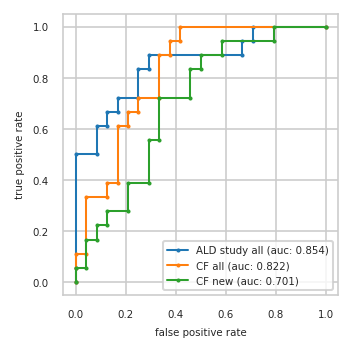

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.111  0.042 0.056
3          0.083 0.500  0.042 0.111  0.042 0.167
4          0.083 0.611  0.042 0.333  0.083 0.167
5          0.125 0.611  0.125 0.333  0.083 0.222
6          0.125 0.667  0.125 0.389  0.125 0.222
7          0.167 0.667  0.167 0.389  0.125 0.278
8          0.167 0.722  0.167 0.611  0.208 0.278
9          0.250 0.722  0.208 0.611  0.208 0.389
10         0.250 0.833  0.208 0.667  0.292 0.389
11         0.292 0.833  0.250 0.667  0.292 0.556
12         0.292 0.889  0.250 0.722  0.333 0.556
13         0.667 0.889  0.333 0.722  0.333 0.722
14         0.667 0.944  0.333 0.889  0.458 0.722
15         0.708 0.944  0.375 0.889  0.458 0.833
16         0.708 1.000  0.375 0.944  0.500 0.833
17         1.000 1.000  0.417 0.944  0.500 0.889
18           NaN   NaN  0.417 1.000  0.583 0.889
19           NaN   NaN  1.000 1.000  0.583 0.944
20           NaN   NaN    NaN   NaN  0.792 0.944
21           NaN   NaN    NaN   NaN  0.792 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,P22676,Q15084;Q15084-2;Q15084-3;Q15084-4;Q15084-5
2,P04114,Q14894,A0A0G2JQ91;Q7Z304
3,P61981,P63104,P31321
4,P14174,A0A0A0MRJ7;P12259,Q96GD0
5,P04075,Q9Y2T3;Q9Y2T3-3,Q9Y281;Q9Y281-3
6,Q9Y2T3;Q9Y2T3-3,P04075,A0A0J9YW36;Q9NZ72;Q9NZ72-2
7,P00338;P00338-3,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,None,P61981,P05556;P05556-2;P05556-3;P05556-4;P05556-5


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


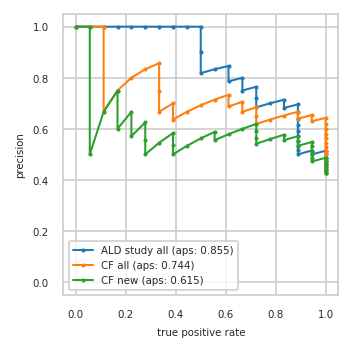

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.500 0.889     0.562 1.000     0.531 0.944
11         0.516 0.889     0.581 1.000     0.548 0.944
12         0.533 0.889     0.600 1.000     0.533 0.889
13         0.552 0.889     0.621 1.000     0.552 0.889
14         0.571 0.889     0.643 1.000     0.571 0.889
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.577 0.833
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.714 0.833     0.619 0.722     0.619 0.722
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.533 0.444
28         0.786 0.611     0.714 0.556     0.500 0.389
29         0.846 0.611     0.692 0.500     0.538 0.389
30         0.833 0.556     0.667 0.444     0.583 0.389
31         0.818 0.500     0.636 0.389     0.545 0.333
32         0.900 0.500     0.700 0.389     0.500 0.278
33         1.000 0.500     0.667 0.333     0.556 0.278
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


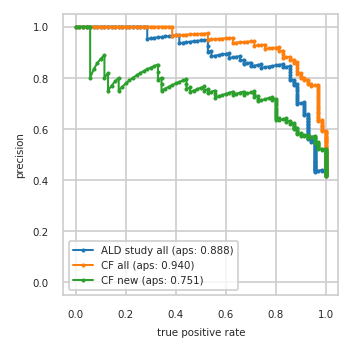

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


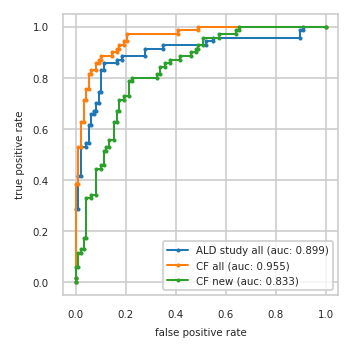

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}